In [1]:
import pcen
import torch
import torchaudio
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pickle
from python_scripts.read_xwav_header import read_xwav_header
from pathlib import Path
import matplotlib.pyplot as plt
from python_scripts.image import Image
import warnings
import math
from copy import deepcopy
from PIL import Image as PILImage
import numpy as np
import sys
import gc

In [2]:
annot = pd.read_csv("data/pifsc_products_detections_annotations.csv")
annot.head()
uncompressed_files = os.listdir("data/audio_data/uncompressed")

In [3]:
uncompressed_files = os.listdir("D:/SonarData/flat")[:50]
uncompressed_files

['Cross_A_01_050514_014345.d20.x.wav',
 'Cross_A_01_050518_040230.d20.x.wav',
 'Cross_A_01_050520_183000.d20.x.wav',
 'Cross_A_01_050520_212731.d20.x.wav',
 'Cross_A_01_050521_004500.d20.x.wav',
 'Cross_A_01_050527_003345.d20.x.wav',
 'Cross_A_01_050606_123845.d20.x.wav',
 'Cross_A_01_050612_151845.d20.x.wav',
 'Cross_A_01_050613_232350.d20.x.wav',
 'Cross_A_01_050630_004730.d20.x.wav',
 'Cross_A_01_050630_222845.d20.x.wav',
 'Cross_A_01_050701_112115.d20.x.wav',
 'Cross_A_01_050702_031345.d20.x.wav',
 'Cross_A_01_050703_170730.d20.x.wav',
 'Cross_A_01_050717_151615.d20.x.wav',
 'Cross_A_01_050722_115500.d20.x.wav',
 'Cross_A_01_050801_074615.d20.x.wav',
 'Cross_A_01_050801_110500.d20.x.wav',
 'Cross_A_01_050908_025000.d20.x.wav',
 'Cross_A_02_051120_000000.d20.x.wav',
 'Cross_A_02_051120_032000.d20.x.wav',
 'Cross_A_02_051120_184730.d20.x.wav',
 'Cross_A_02_051120_220500.d20.x.wav',
 'Cross_A_02_051211_001000.d20.x.wav',
 'Cross_A_02_051211_030730.d20.x.wav',
 'Cross_A_02_051211_12400

In [3]:
transform = pcen.StreamingPCENTransform(s=0.008,
                                    alpha=0.8,
                                    delta=200,
                                    r=0.05,
                                    n_fft=4096,
                                    n_mels=256,
                                    hop_length=300,
                                    sr=10_000,
                                    window=torch.hann_window(4096),
                                    return_complex=False,
                                    # normalized=True,
                                    f_max=4000,
                                    f_min=10,
                                    )

In [4]:
# find all files in D:/SonarData/spectrograms with os.walk
processed_files = set()
for root, dirs, files in os.walk("D:/SonarData/spectrograms"):
    for file in files:
        if file.endswith(".png"):
            # print(root, file)
            f = "_".join(file.split("_")[:5])
            processed_files.add(f)
list(processed_files)[:10], len(processed_files)

(['Cross_A_02_060207_105313',
  'Equator_A_01_120525_182115',
  'Hawaii_K_02_080517_040345',
  'Hawaii_K_06_090505_164500',
  'Hawaii_K_07_091211_113000',
  'Hawaii_K_10_110211_000000',
  'Hawaii_K_11_110921_075430',
  'Cross_A_02_060210_080313',
  'Cross_A_02_060121_005428',
  'Cross_A_02_060206_031158'],
 516)

In [5]:
# Better implementation
uncompressed_files = os.listdir("D:/SonarData/flat")
uncompressed_files = [i for i in uncompressed_files if i.split(".")[-1] == 'wav']
# uncompressed_files = os.listdir("data/audio_data/uncompressed")
# uncompressed_files = ["Cross_A_02_060116_221158.d20.x.wav"]
lst = []
for idx, file_name in enumerate(uncompressed_files):
    
    file_path = Path(f"D:/SonarData/flat/{file_name}")
    # file_path = Path(f"data/audio_data/uncompressed/{file_name}")
    # print(file_name)
    filter_filename = file_name.split(".")[0]
    if filter_filename in processed_files:
        print(f"Skipping {filter_filename}")
        continue
    else:
        print(f"Processing {filter_filename}")
    
    classifications = annot[annot['flac_compressed_xwav_object'].str.contains(filter_filename)]
    
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 10_000:
        raise ValueError("Sample rate is not 10,000")
    spec = None
    for index, row in classifications.iterrows():
        # print(index, row["label"])
        img = Image()
        img.image_path = file_path
        img.classification = row['label']
        img.riff_header, img.harp_header, img.harp_subchunk_headers = read_xwav_header(file_path)
        img.transform_metadata = transform.__dict__
        # print(f"Classification: {img.classification}")
        
        subchunk_index = row["subchunk_index"]
        header_size = 8 + 44 + img.harp_header["harp_subchunk_size"]
        
        if subchunk_index == 0:
            subchunk_of_interest = 0
            prev_subchunk_index = 0
        elif subchunk_index == max(img.harp_subchunk_headers.keys()):
            subchunk_of_interest = 2
            prev_subchunk_index = subchunk_index - 2
        else:
            subchunk_of_interest = 1
            prev_subchunk_index = subchunk_index - 1
        # print(f"Subchunk of interest: {subchunk_of_interest}")
        prev_subchunk = img.harp_subchunk_headers[prev_subchunk_index]
        if (prev_subchunk["byte_loc"] - header_size) % prev_subchunk["byte_len"] != 0:
            warnings.warn(f"Subchunk {subchunk_index-1} is not aligned with byte_len in file {file_name}, skipping...")
            continue
        if prev_subchunk["byte_len"] != 1_500_000 or prev_subchunk["sample_rate"] != 10_000:
            warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")
            continue
        
        byte_length = prev_subchunk["byte_len"]/2
        byte_loc = (prev_subchunk["byte_loc"] - header_size)/2
        start, end = int(byte_loc), int(byte_loc + (byte_length * 3))
        sub_waveform = waveform[:, start:end]
        spec = transform(sub_waveform)
        # print(f"Subwaveform shape: {sub_waveform.shape}")
        
        
        start, end = (subchunk_of_interest * 75) + row["begin_rel_subchunk"], (subchunk_of_interest * 75) + row["end_rel_subchunk"]
        total = sub_waveform.shape[1] / img.riff_header["sample_rate"]  # gets length of sliced file in seconds
        # print(f"total seconds: {total}")
        if total != 225:  # should always be 3 subchunks long 3 * 75 = 225
            warnings.warn(f"Total seconds is not 225 {start}, {end}, {total}")
            
        p_start, p_end = start / total, end / total
        spec_length = spec.shape[1]
        img.spec_length = spec_length
        # print(f"spec length: {spec_length}")
        spec_start, spec_end = int(p_start * spec_length), int(p_end * spec_length)
        spec_diff = spec_end - spec_start
        
        
        # Don't actually know if this works, pretty sure it does
        extra_bins = 256 - spec_diff % 256
        spec_start, spec_end = spec_start - extra_bins // 2, spec_end + extra_bins // 2
        if spec_start < 0:
            spec_end += abs(spec_start)
            spec_start = 0
        elif spec_end > spec_length:
            spec_start -= spec_end - spec_length
            spec_end = spec_length
        for i in range(spec_start, spec_end, 256):
            # print(i, i+256)
            # print(i)
            new_img = deepcopy(img)
            new_img.image_name = f"{filter_filename}_{index}_{i}"
            actual_image = spec[0][i:i+256, :].numpy()
            new_img.image_shape = actual_image.shape
            new_img.image_data = actual_image
            
            new_img.spec_start_bin = spec_start
            new_img.spec_end_bin = spec_end
            new_img.spec_diff_bin = spec_diff
            
            new_img.spec_start_time = start
            new_img.spec_end_time = end
            new_img.spec_diff_time = end - start
            
            lst.append(new_img)
    del spec, waveform
    if (idx+1) % 5 == 0:
        print(f"Processing file {idx+1} of {len(uncompressed_files)}")
        for img in lst:
            img.save_image(Path("D:/SonarData/spectrograms/more1"), str(idx))
        if lst:
            with open(f"D:/SonarData/spectrograms/more1/{idx}/image_data_{idx}.pkl", "wb") as f:
                pickle.dump(lst, f)
        del lst
        lst = []

for img in lst:
    img.save_image(Path("D:/SonarData/spectrograms/more1"), str(idx))
if lst:
    with open(f"D:/SonarData/spectrograms/more1/{idx}/image_data_{idx}.pkl", "wb") as f:
        pickle.dump(lst, f)
del lst

Skipping Cross_A_01_050514_014345
Skipping Cross_A_01_050518_040230
Skipping Cross_A_01_050520_183000
Skipping Cross_A_01_050520_212731
Skipping Cross_A_01_050521_004500
Skipping Cross_A_01_050527_003345
Skipping Cross_A_01_050606_123845
Skipping Cross_A_01_050612_151845
Skipping Cross_A_01_050613_232350
Skipping Cross_A_01_050630_004730
Skipping Cross_A_01_050630_222845
Skipping Cross_A_01_050701_112115
Skipping Cross_A_01_050702_031345
Skipping Cross_A_01_050703_170730
Skipping Cross_A_01_050717_151615
Skipping Cross_A_01_050722_115500
Skipping Cross_A_01_050801_074615
Skipping Cross_A_01_050801_110500
Skipping Cross_A_01_050908_025000
Skipping Cross_A_02_051120_000000
Skipping Cross_A_02_051120_032000
Skipping Cross_A_02_051120_184730
Skipping Cross_A_02_051120_220500
Skipping Cross_A_02_051211_001000
Skipping Cross_A_02_051211_030730
Skipping Cross_A_02_051211_124000
Skipping Cross_A_02_051218_005615
Skipping Cross_A_02_051220_173230
Skipping Cross_A_02_051221_030500
Skipping Cross

C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:49: UserWarning: Subchunk 24 is not aligned with byte_len in file Cross_A_02_060116_221158.d20.x.wav, skipping...
  warnings.warn(f"Subchunk {subchunk_index-1} is not aligned with byte_len in file {file_name}, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:49: UserWarning: Subchunk 5 is not aligned with byte_len in file Cross_A_02_060116_221158.d20.x.wav, skipping...
  warnings.warn(f"Subchunk {subchunk_index-1} is not aligned with byte_len in file {file_name}, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:49: UserWarning: Subchunk 20 is not aligned with byte_len in file Cross_A_02_060213_080543.d20.x.wav, skipping...
  warnings.warn(f"Subchunk {subchunk_index-1} is not aligned with byte_len in file {file_name}, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:49: UserWarning: Subchunk 17 is not aligned with byte_len in file Cross_A_02_

Skipping Cross_A_02_060213_105928
Skipping Cross_A_02_060213_135658
Skipping Cross_A_02_060213_201158
Skipping Cross_A_02_060214_022813
Skipping Cross_A_02_060214_122428
Skipping Cross_A_02_060214_183928
Skipping Cross_A_02_060214_213658
Skipping Cross_A_02_060215_005428
Skipping Cross_A_02_060215_070928
Skipping Cross_A_02_060215_132543
Skipping Cross_A_02_060215_223813
Skipping Cross_A_02_060216_015543
Skipping Cross_A_02_060216_172313
Skipping Cross_A_02_060217_120813
Skipping Cross_A_02_060219_034313
Skipping Cross_A_02_060222_002428
Skipping Cross_A_02_060222_032158
Skipping Cross_A_02_060222_155158
Skipping Cross_A_02_060223_012813
Skipping Cross_A_02_060224_025313
Skipping Cross_A_02_060224_061043
Skipping Cross_A_02_060225_134928
Skipping Cross_A_02_060225_164658
Skipping Cross_A_02_060226_233813
Skipping Cross_A_02_060227_091043
Skipping Cross_A_02_060227_120813
Skipping Cross_A_02_060302_023813
Skipping Cross_A_02_060302_150813
Skipping Cross_A_02_060303_004313
Skipping Cross

C:\Users\adria\anaconda3\envs\ml\lib\site-packages\torch\functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:879.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


Processing Hawaii_K_14_130118_041230
Processing Hawaii_K_14_130120_005345
Processing Hawaii_K_14_130121_214000
Processing Hawaii_K_14_130123_182115
Processing file 525 of 1012
Processing Hawaii_K_14_130125_150230
Processing Hawaii_K_14_130127_114345
Processing Hawaii_K_14_130128_051115
Processing Hawaii_K_14_130130_015230
Processing Hawaii_K_14_130131_223345
Processing file 530 of 1012
Processing Hawaii_K_14_130202_192000
Processing Hawaii_K_14_130204_160115
Processing Hawaii_K_14_130206_124230
Processing Hawaii_K_14_130208_092345
Processing Hawaii_K_14_130210_061000
Processing file 535 of 1012
Processing Hawaii_K_14_130212_025115
Processing Hawaii_K_14_130213_233230
Processing Hawaii_K_14_130215_201345
Processing Hawaii_K_14_130217_170000
Processing Hawaii_K_14_130219_134115
Processing file 540 of 1012
Processing Hawaii_K_14_130221_102230
Processing Hawaii_K_14_130223_070345
Processing Hawaii_K_14_130225_035000
Processing Hawaii_K_14_130227_003115
Processing Hawaii_K_15_130527_190000


C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1605 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1626 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")


Processing Hawaii_K_20_320_150616_145248_df32


C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1573 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1593 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")


Processing Hawaii_K_20_320_150706_103140_df32


C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1602 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1622 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")


Processing file 725 of 1012
Processing Hawaii_K_20_320_150801_174730_df32


C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1580 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:52: UserWarning: Subchunk 1601 is not 1500000 bytes long, skipping...
  warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")


Processing Kauai_A_01_091003_014800
Processing Kauai_A_01_091121_094345
Processing Kauai_A_01_091128_204115
Processing Kauai_A_01_091204_232230
Processing file 730 of 1012
Processing Kauai_A_01_091208_164345
Processing Kauai_A_01_091212_102000
Processing Kauai_A_01_091214_194000
Processing Kauai_A_01_091218_130115
Processing Kauai_A_01_091222_062230
Processing file 735 of 1012
Processing Kauai_A_01_091225_234345
Processing Kauai_A_01_091228_090345
Processing Kauai_A_01_100101_024000
Processing Kauai_A_01_100104_200115
Processing Kauai_A_01_100108_132230
Processing file 740 of 1012
Processing Kauai_A_01_100110_224230
Processing Kauai_A_01_100114_160345
Processing Kauai_A_01_100118_094000
Processing Kauai_A_01_100122_030115
Processing Kauai_A_01_100124_122115
Processing file 745 of 1012
Processing Kauai_A_01_100128_054230
Processing Kauai_A_01_100131_230345
Processing Kauai_A_01_100204_164000
Processing Kauai_A_01_100207_020000
Processing Kauai_A_01_100210_192115
Processing file 750 of 1

C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:49: UserWarning: Subchunk 24 is not aligned with byte_len in file Palmyra_WT_05_080615_083823.d20.x.wav, skipping...
  warnings.warn(f"Subchunk {subchunk_index-1} is not aligned with byte_len in file {file_name}, skipping...")
C:\Users\adria\AppData\Local\Temp\ipykernel_21916\210973141.py:49: UserWarning: Subchunk 1 is not aligned with byte_len in file Palmyra_WT_05_080615_124042.d20.x.wav, skipping...
  warnings.warn(f"Subchunk {subchunk_index-1} is not aligned with byte_len in file {file_name}, skipping...")


Processing Palmyra_WT_05_080711_024115
Processing Palmyra_WT_05_080802_000345
Processing Palmyra_WT_05_080802_024115
Processing file 890 of 1012
Processing Palmyra_WT_05_080907_220345
Processing PHR_A_01_091027_104000
Processing PHR_A_01_091129_162345
Processing PHR_A_01_091230_130230
Processing PHR_A_01_100123_014345
Processing file 895 of 1012
Processing PHR_A_01_100126_192000
Processing PHR_A_01_100216_194115
Processing PHR_A_01_100304_184000
Processing PHR_A_01_100318_082230
Processing PHR_A_01_100322_014345
Processing file 900 of 1012
Processing PHR_A_01_100325_192000
Processing PHR_A_01_100418_050115
Processing PHR_A_01_100421_222230
Processing PHR_A_01_100425_154345
Processing PHR_A_05_110913_033714
Processing file 905 of 1012
Processing PHR_A_05_111001_205559
Processing PHR_A_05_111110_073144
Processing PHR_A_05_111128_145559
Processing PHR_A_06_130216_163230
Processing Saipan_A_01_100401_024000
Processing file 910 of 1012
Processing Saipan_A_01_100423_104345
Processing Saipan_

In [3]:
lst = []
for idx, file_name in enumerate(uncompressed_files):
    
    file_path = Path(f"D:/SonarData/flat/{file_name}")
    print(file_name)
    filter_filename = file_name.split(".")[0]
    
    classifications = annot[annot['flac_compressed_xwav_object'].str.contains(filter_filename)]
    
    waveform, sample_rate = torchaudio.load(file_path)
    # print(file_name)
    transform = pcen.StreamingPCENTransform(s=0.008,
                                        alpha=0.8,
                                        delta=200,
                                        r=0.05,
                                        n_fft=4096,
                                        n_mels=256,
                                        hop_length=300,
                                        sr=sample_rate,
                                        window=torch.hann_window(4096),
                                        return_complex=False,
                                        # normalized=True,
                                        f_max=4000,
                                        f_min=10,
                                        )
    spec_gram = transform(waveform)
    
    for index, row in classifications.iterrows():
        # print(index, row["label"])
        img = Image()
        img.image_path = file_path
        img.classification = row['label']
        img.riff_header, img.harp_header, img.harp_subchunk_headers = read_xwav_header(file_path)
        img.transform_metadata = transform.__dict__
        
        
        
        subchunk_index = row["subchunk_index"]
        header_size = 8 + 44 + img.harp_header["harp_subchunk_size"]
        subchunk = img.harp_subchunk_headers[subchunk_index]
        if (subchunk["byte_loc"] - header_size) % subchunk["byte_len"] != 0:
            warnings.warn(f"Subchunk {subchunk_index} is not aligned with byte_len in file {file_name}, skipping...")
            continue
        if subchunk["byte_len"] != 1_500_000 or subchunk["sample_rate"] != 10_000:
            warnings.warn(f"Subchunk {subchunk_index} is not 1500000 bytes long, skipping...")
            continue
        
        start, end = (subchunk_index * 75) + row["begin_rel_subchunk"], (subchunk_index * 75) + row["end_rel_subchunk"]
        total = (img.riff_header['chunk_size'] - header_size) / img.riff_header["byte_rate"]  # how many seconds long the file is
        
        p_start, p_end = start / total, end / total  # percentage of the way through the file the start and end times are
        spec_length = spec_gram.shape[1]
        img.spec_length = spec_length
        
        spec_start, spec_end = int(p_start * spec_length), int(p_end * spec_length)
        spec_diff = spec_end - spec_start
        
        # Don't actually know if this works, pretty sure it does
        extra_bins = 256 - spec_diff % 256
        spec_start, spec_end = spec_start - extra_bins // 2, spec_end + extra_bins // 2
        if spec_start < 0:
            spec_end += abs(spec_start)
            spec_start = 0
        elif spec_end > spec_length:
            spec_start -= spec_end - spec_length
            spec_end = spec_length
        for i in range(spec_start, spec_end, 256):
            # print(i, i+256)
            new_img = deepcopy(img)
            new_img.image_name = f"{filter_filename}_{index}_{i}"
            actual_image = spec_gram[0][i:i+256, :].numpy()
            new_img.image_shape = actual_image.shape
            new_img.image_data = actual_image
            
            new_img.spec_start_bin = spec_start
            new_img.spec_end_bin = spec_end
            new_img.spec_diff_bin = spec_diff
            
            new_img.spec_start_time = start
            new_img.spec_end_time = end
            new_img.spec_diff_time = end - start
            
            lst.append(new_img)
    # print()
    # print(idx + 1)
    # print()
    del spec_gram, waveform
    if (idx+1) % 10 == 0:
        print(f"Processing file {idx+1} of {len(uncompressed_files)}")
        for img in lst:
            img.save_image(Path("data/spectrograms/more"), str(idx))
        with open(f"data/spectrograms/more/{idx}/image_data.pkl", "wb") as f:
            pickle.dump(lst, f)
        lst = []
        
    
    
        # continue
        # 
        # 
        # 
        # if spec_diff > 256:
        #     warnings.warn(f"Classification {index} is too long, skipping...")
        #     continue
        # 
        # extra_bins = 256 - spec_diff
        # if spec_start-extra_bins < 0:
        #     spec_start = 0
        #     spec_end = 256
        #     # print(f"a: {spec_end - spec_start}")
        # elif spec_end+extra_bins > spec_length:
        #     spec_start = spec_end - 256
        #     spec_end = spec_length
        #     # print(f"b: {spec_end - spec_start}")
        # else:
        #     spec_start -= math.floor(extra_bins / 2)
        #     spec_end += math.ceil(extra_bins / 2)
        #     # print(f"c: {spec_end - spec_start}")
        # 
        # actual_image = spec_gram[0][spec_start:spec_end, :].numpy()
        # img.image_shape = actual_image.shape
        # img.image_data = actual_image
        # 
        # img.spec_start_bin = spec_start
        # img.spec_end_bin = spec_end
        # img.spec_diff_bin = spec_diff
        # 
        # img.spec_start_time = start
        # img.spec_end_time = end
        # img.spec_diff_time = end - start
        # 
        # lst.append(img)
    
        
    

Cross_A_01_050606_123845.d20.x.wav


C:\Users\adria\anaconda3\envs\ml\lib\site-packages\torch\functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:879.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


Cross_A_01_050702_031345.d20.x.wav
Cross_A_01_050801_074615.d20.x.wav
Cross_A_01_050801_110500.d20.x.wav
Cross_A_01_050908_025000.d20.x.wav
Cross_A_02_060508_234813.d20.x.wav
Equator_A_01_120313_165615.df20.x.wav


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 43950096384 bytes.

In [66]:
a, b = lst[-1], lst[-2]
a.image_name, b.image_name

('Cross_A_02_060114_135428_21469', 'Cross_A_02_060114_135428_21469')

In [68]:
for img in lst:
    img.save_image(Path("data/spectrograms/more"), "train")

In [60]:
lst
for img in lst[:-10]:
   img.save_image(Path("data/spectrograms"), "train") 
with open("data/spectrograms/train/image_data.pkl", "wb") as f:
       pickle.dump(lst[:-10], f)

for img in lst[-10:]:
    img.save_image(Path("data/spectrograms"), "test")
with open("data/spectrograms/test/image_data.pkl", "wb") as f:
       pickle.dump(lst[-10:], f)

In [61]:
annot.loc[21461]

audit_name                                                               postpub
flac_compressed_xwav_object    gs://noaa-passive-bioacoustic/pifsc/audio/pipa...
subchunk_index                                                                14
label_is_strong                                                            False
implicit_negatives                                                         False
label                                                                     Vessel
begin_rel_subchunk                                                           0.0
end_rel_subchunk                                                            75.0
begin_utc                                              2006-01-07 03:43:57+00:00
end_utc                                                2006-01-07 03:45:12+00:00
Name: 21461, dtype: object

In [13]:
with open("data/spectrograms/image_data.pkl", "wb") as f:
    pickle.dump(lst, f)

In [9]:
len(lst[:-10]), len(lst[-10:])

(106, 10)

In [4]:
lst[0].save_image(Path("data/spectrograms"), "train")

In [7]:
lst[0].image_data.max(), lst[0].image_data.min()

(0.0027159452, 2.014637e-05)

In [29]:
lst[0].save_image(Path("data/spectrograms"), "train")

AttributeError: type object 'Image' has no attribute 'fromarray'

In [19]:
annot[annot['flac_compressed_xwav_object'].str.contains("Cross_A_02_060508")]

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc
7168,model2,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,14,True,False,Mn,19.5,20.46,2006-05-08 22:08:32.500000+00:00,2006-05-08 22:08:33.460000+00:00
7169,model2,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,23,True,False,Mn,71.5,72.46,2006-05-09 02:18:09.500000+00:00,2006-05-09 02:18:10.460000+00:00
21587,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,22,False,False,Vessel,0.0,75.00,2006-05-09 02:15:43+00:00,2006-05-09 02:16:58+00:00


In [101]:
data['header']

({'chunk_id': b'RIFF',
  'chunk_size': 45001060,
  'format': b'WAVE',
  'subchunk1_id': b'fmt ',
  'subchunk1_size': 16,
  'audio_format': 1,
  'num_channels': 1,
  'sample_rate': 10000,
  'byte_rate': 20000,
  'block_align': 2,
  'bits_per_sample': 16},
 {'harp_subchunk_id': b'harp',
  'harp_subchunk_size': 1016,
  'wav_version_number': 1,
  'firmware_version_number': b'1.17\x00\x00\x00\x00\x00\x00',
  'instrument_id': b'DL15',
  'site_name': b'DL15',
  'experiment_name': b'Hawai06K',
  'disk_sequence_number': 2,
  'disk_serial_number': b'12345678',
  'num_of_raw_files': 30,
  'longitude': -156.00947,
  'latitude': 19.34957,
  'depth': 620,
  'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00'},
 defaultdict(dict,
             {0: {'year': 9,
               'month': 5,
               'day': 5,
               'hour': 16,
               'minute': 45,
               'second': 0,
               'ticks': 0,
               'byte_loc': 1068,
               'byte_len': 1500000,
               'wr

In [104]:
new_header = read_xwav_header("data/audio_data/uncompressed/Equator_A_01_120313_165615.df20.x.wav")

In [105]:
new_header

({'chunk_id': b'RIFF',
  'chunk_size': 1609534436,
  'format': b'WAVE',
  'subchunk1_id': b'fmt ',
  'subchunk1_size': 16,
  'audio_format': 1,
  'num_channels': 1,
  'sample_rate': 10000,
  'byte_rate': 20000,
  'block_align': 2,
  'bits_per_sample': 16},
 {'harp_subchunk_id': b'harp',
  'harp_subchunk_size': 34392,
  'wav_version_number': 1,
  'firmware_version_number': b'V2.02Q\x00\x00\x00\x00',
  'instrument_id': b'DL10',
  'site_name': b'____',
  'experiment_name': b'Equator1',
  'disk_sequence_number': 2,
  'disk_serial_number': b'12345678',
  'num_of_raw_files': 1073,
  'longitude': -164.08079,
  'latitude': 0.26607,
  'depth': 1266,
  'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00'},
 defaultdict(dict,
             {0: {'year': 12,
               'month': 3,
               'day': 13,
               'hour': 16,
               'minute': 56,
               'second': 15,
               'ticks': 0,
               'byte_loc': 34444,
               'byte_len': 1500000,
               

In [97]:
transform.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict([('last_state',
               tensor([[[0.0901, 0.0939, 0.0829, 0.0865, 0.1026, 0.1156, 0.2446, 0.4726,
                         0.0985, 0.0870, 0.0851, 0.1218, 0.1025, 0.0943, 0.0756, 0.2784,
                         0.2796, 0.0829, 0.0789, 0.1163, 0.0891, 0.0563, 0.0583, 0.1213,
                         0.2007, 0.0516, 0.0501, 0.0523, 0.0633, 0.0574, 0.0442, 0.0730,
                         0.0740, 0.0522, 0.0589, 0.0458, 0.0373, 0.1532, 0.2162, 0.1330,
                         0.0430, 0.0558, 0.0671, 0.0596, 0.0463, 0.0751, 0.0938, 0.0611,
                         0.0790, 0.0695, 0.0710, 0.0607, 0.0981, 0.1096, 0.0846, 0.0796,
                         0.0707, 0.0811, 0.0860, 0.0828, 0.0608, 0.0657, 0.0509, 0.0755,
                         0.0776, 0.0773, 0.0691, 0.0794, 0.0625, 0.0675, 0.0755, 0.0675,
                         0.0572, 0.0614, 0.0585, 0.0462, 0.0766, 0.0478, 0.0474, 0.0447,
                   

24665


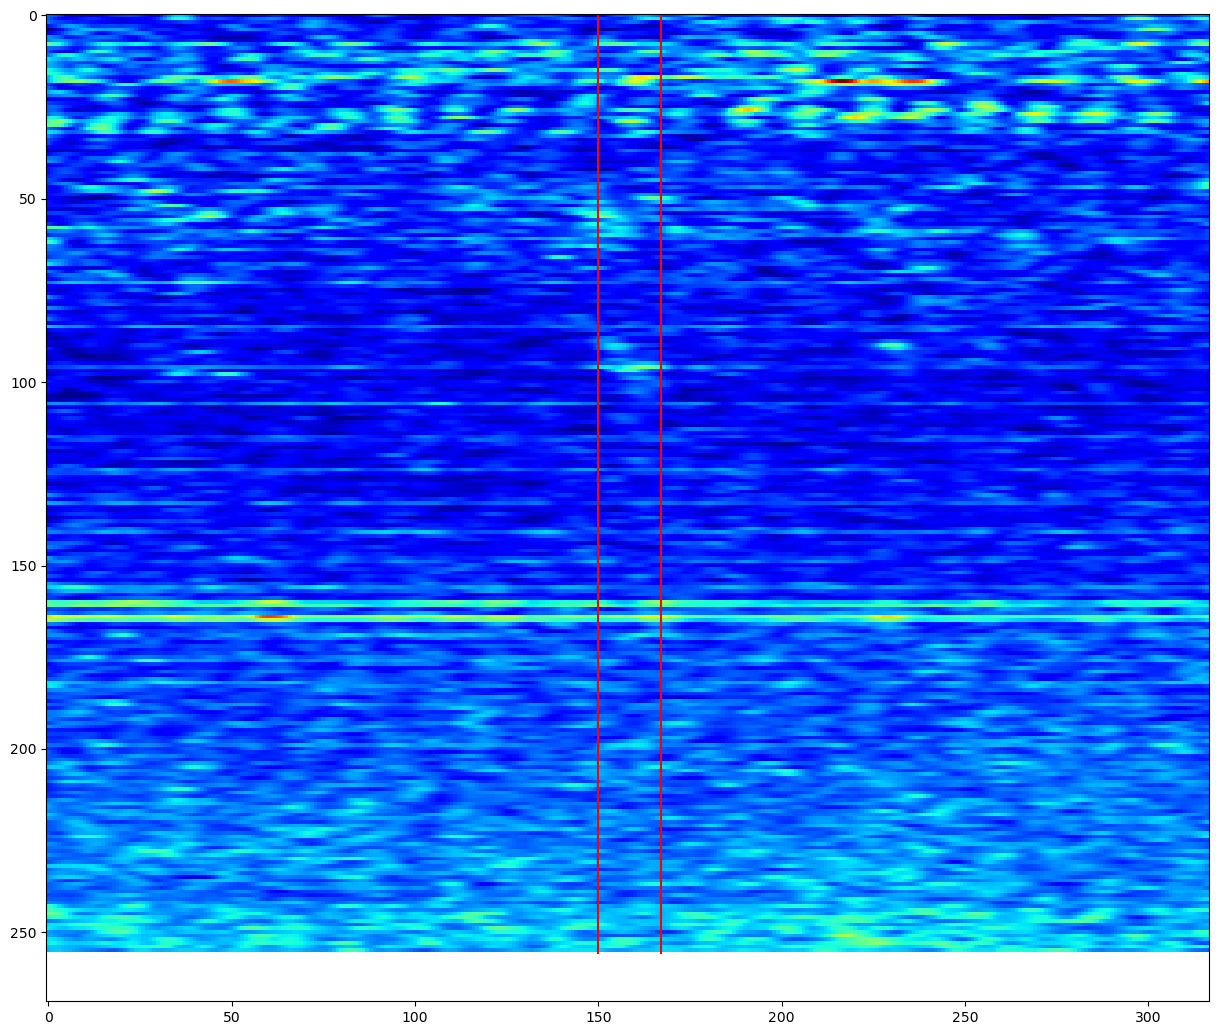

In [85]:
transform = pcen.StreamingPCENTransform(s=0.002,
                                        alpha=0.6,
                                        delta=500,
                                        r=0.05,
                                        n_fft=8192,
                                        n_mels=256,
                                        hop_length=400,
                                        sr=10_000,
                                        window=torch.hann_window(8192),
                                        return_complex=False,
                                        # normalized=True,
                                        f_max=3000,
                                        f_min=,
                                        )

out = transform(waveform)

start, end = 11*75 + 48.174, 11*75 + 49.138
start, end = 13*75 + 11.6, 13*75 + 12.3
total = (data["header"][0]['chunk_size'] - 1060) / 20_000
p_start, p_end = start / total, end / total
spec_length = out.shape[1]
spec_start, spec_end = int(p_start * spec_length), int(p_end * spec_length)
print(spec_start)
spec_diff = spec_end - spec_start
spec_start, spec_end = max(0, spec_start - 150), min(spec_length, spec_end + 150)
plt.figure(figsize=(15,25))
plt.imshow(out[0][spec_start:spec_end, :].T.numpy(), cmap='jet', interpolation="none")
plt.vlines([150, 150 + spec_diff], 0, out.shape[2], color='red')

plt.show()

In [80]:
out.shape

torch.Size([1, 45001, 256])

In [161]:
2250/64286

0.0349998444451358

In [62]:
out.shape

torch.Size([1, 75001, 256])

In [75]:
out[0][100:400, :].shape

torch.Size([300, 256])

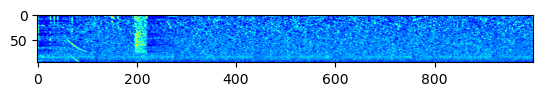

In [134]:
plt.imshow(out[0][:1_000, :].T.numpy(), cmap='jet')

In [108]:
start, end = 11*75 + 48.174, 11*75 + 49.138
total = (data["header"][0]['chunk_size'] - 1060) / 20_000
p_start, p_end = start / total, end / total
p_start, p_end

(0.38807733333333333, 0.3885057777777778)

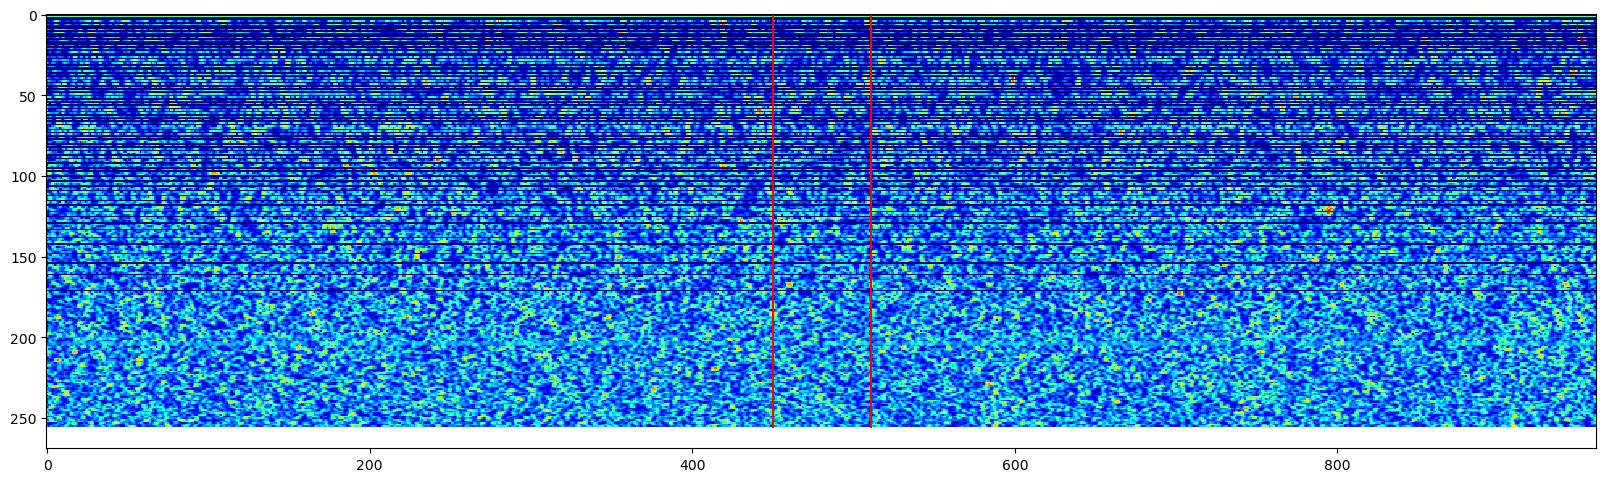

In [150]:
spec_length = out.shape[1]
spec_start, spec_end = int(p_start * spec_length), int(p_end * spec_length)
spec_diff = spec_end - spec_start
spec_start, spec_end = max(0, spec_start - 450), min(spec_length, spec_end + 450)
plt.figure(figsize=(20,20))
plt.imshow(out[0][spec_start:spec_end, :].T.numpy(), cmap='jet', interpolation="none")
plt.vlines([450, 450 + spec_diff], 0, out.shape[2], color='red')

plt.show()

In [125]:
(11*75) + 48.174

873.174

In [7]:
data['header']

({'chunk_id': b'RIFF',
  'chunk_size': 45001060,
  'format': b'WAVE',
  'subchunk1_id': b'fmt ',
  'subchunk1_size': 16,
  'audio_format': 1,
  'num_channels': 1,
  'sample_rate': 10000,
  'byte_rate': 20000,
  'block_align': 2,
  'bits_per_sample': 16},
 {'harp_subchunk_id': b'harp',
  'harp_subchunk_size': 1016,
  'wav_version_number': 1,
  'firmware_version_number': b'1.17\x00\x00\x00\x00\x00\x00',
  'instrument_id': b'DL13',
  'site_name': b'CSM1',
  'experiment_name': b'Cross_01',
  'disk_sequence_number': 4,
  'disk_serial_number': b'12345678',
  'num_of_raw_files': 30,
  'longitude': -18.43343,
  'latitude': 158.15221,
  'depth': 396,
  'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00'},
 defaultdict(dict,
             {0: {'year': 5,
               'month': 6,
               'day': 6,
               'hour': 12,
               'minute': 38,
               'second': 45,
               'ticks': 0,
               'byte_loc': 1068,
               'byte_len': 1500000,
               'w

In [9]:
waveform.shape

torch.Size([1, 22500000])

In [ ]:
lst = []
for file in uncompressed_files:
    data = {}
    if "Equator" in file:
        continue
    file_path = f"data/audio_data/uncompressed/{file}"
    data["file_name"] = file
    data["file_path"] = file_path
    data["header"] = read_xwav_header(file_path)
    
    waveform, sample_rate = torchaudio.load(file_path)
    
    del waveform
    pcen_spec = model.front_end(w)
    del w
    data["pcen_spec"] = pcen_spec
    lst.append(data)